In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [3]:
def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/Users/douwe/Dropbox/Douwe/Proj/notebooks/venv3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((3937, 32, 32, 1), (695, 32, 32, 1))

In [4]:
x_train.shape

(3937, 32, 32, 1)

In [5]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 4)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 8)    0           conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
__________

In [6]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 3937 samples, validate on 695 samples
Epoch 1/100
3937/3937 [==============================] - 4s 928us/step - loss: 0.5603 - val_loss: 0.5260
Epoch 2/100
3937/3937 [==============================] - 4s 892us/step - loss: 0.5218 - val_loss: 0.5092
Epoch 3/100
3937/3937 [==============================] - 4s 896us/step - loss: 0.5122 - val_loss: 0.5041
Epoch 4/100
3937/3937 [==============================] - 4s 906us/step - loss: 0.5054 - val_loss: 0.5004
Epoch 5/100
3937/3937 [==============================] - 4s 930us/step - loss: 0.5042 - val_loss: 0.4996
Epoch 6/100
3937/3937 [==============================] - 4s 929us/step - loss: 0.4994 - val_loss: 0.4958
Epoch 7/100
3937/3937 [==============================] - 4s 898us/step - loss: 0.4970 - val_loss: 0.4976
Epoch 8/100
3937/3937 [==============================] - 4s 916us/step - loss: 0.4935 - val_loss: 0.4915
Epoch 9/100
3937/3937 [==============================] - 4s 958us/step - loss: 0.4905 - val_loss: 0.4830
Epoch 10

3937/3937 [==============================] - 5s 1ms/step - loss: 0.3790 - val_loss: 0.3793
Epoch 80/100
3937/3937 [==============================] - 5s 1ms/step - loss: 0.3785 - val_loss: 0.3813
Epoch 81/100
3937/3937 [==============================] - 5s 1ms/step - loss: 0.3771 - val_loss: 0.3799
Epoch 82/100
3937/3937 [==============================] - 6s 1ms/step - loss: 0.3774 - val_loss: 0.3797
Epoch 83/100
3937/3937 [==============================] - 6s 1ms/step - loss: 0.3776 - val_loss: 0.3788
Epoch 84/100
3937/3937 [==============================] - 7s 2ms/step - loss: 0.3765 - val_loss: 0.3798
Epoch 85/100
3937/3937 [==============================] - 6s 2ms/step - loss: 0.3769 - val_loss: 0.3799
Epoch 86/100
3937/3937 [==============================] - 7s 2ms/step - loss: 0.3757 - val_loss: 0.3771
Epoch 87/100
3937/3937 [==============================] - 7s 2ms/step - loss: 0.3754 - val_loss: 0.3761
Epoch 88/100
3937/3937 [==============================] - 6s 2ms/step - loss:

In [7]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

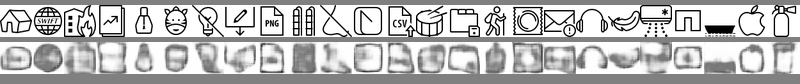

In [9]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [10]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)


In [11]:
x_train_aug = augment(x_train)
x_test_aug = augment(x_test)

In [12]:
x_train_aug.shape

(62992, 32, 32, 1)

In [14]:
from keras.callbacks import TensorBoard
autoencoder = create_autoencoder()
autoencoder.fit(x_train_aug, x_train_aug,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_aug, x_test_aug),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 62992 samples, validate on 11120 samples
Epoch 1/100
62992/62992 [==============================] - 72s 1ms/step - loss: 0.5076 - val_loss: 0.4642
Epoch 2/100
62992/62992 [==============================] - 76s 1ms/step - loss: 0.4403 - val_loss: 0.4240
Epoch 3/100
62992/62992 [==============================] - 75s 1ms/step - loss: 0.4143 - val_loss: 0.4082
Epoch 4/100
62992/62992 [==============================] - 76s 1ms/step - loss: 0.3990 - val_loss: 0.3945
Epoch 5/100
62992/62992 [==============================] - 87s 1ms/step - loss: 0.3884 - val_loss: 0.3929
Epoch 6/100
62992/62992 [==============================] - 77s 1ms/step - loss: 0.3807 - val_loss: 0.3807
Epoch 7/100
62992/62992 [==============================] - 70s 1ms/step - loss: 0.3754 - val_loss: 0.3733
Epoch 8/100
62992/62992 [==============================] - 71s 1ms/step - loss: 0.3706 - val_loss: 0.3760
Epoch 9/100
62992/62992 [==============================] - 71s 1ms/step - loss: 0.3668 - val_loss: 0.3

Epoch 77/100
62992/62992 [==============================] - 59s 929us/step - loss: 0.3127 - val_loss: 0.3130
Epoch 78/100
62992/62992 [==============================] - 60s 949us/step - loss: 0.3124 - val_loss: 0.3180
Epoch 79/100
62992/62992 [==============================] - 62s 985us/step - loss: 0.3120 - val_loss: 0.3142
Epoch 80/100
62992/62992 [==============================] - 65s 1ms/step - loss: 0.3117 - val_loss: 0.3127
Epoch 81/100
62992/62992 [==============================] - 66s 1ms/step - loss: 0.3113 - val_loss: 0.3167
Epoch 82/100
62992/62992 [==============================] - 64s 1ms/step - loss: 0.3112 - val_loss: 0.3148
Epoch 83/100
62992/62992 [==============================] - 67s 1ms/step - loss: 0.3108 - val_loss: 0.3101
Epoch 84/100
62992/62992 [==============================] - 64s 1ms/step - loss: 0.3106 - val_loss: 0.3096
Epoch 85/100
62992/62992 [==============================] - 62s 990us/step - loss: 0.3102 - val_loss: 0.3107
Epoch 86/100
62992/62992 [===

In [15]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

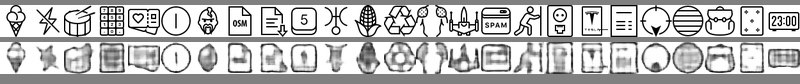

In [17]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

